<a href="https://colab.research.google.com/github/sergiobm3/ESI_MachineLearning/blob/Supervised/Dengue_KNN_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  The Problem


We will use the data from the competition to predict the evolution of Dengue Disease in both Iquitos and San Juan. More information in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

The objective of the exercise is to solve a regression problem and on the other hand to participate in a data competition.


# Setting Preliminares

Before starting any analysis we must ensure that the basic and general use libraries (numpy, pandas, etc.) are correctly imported. 

In [13]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelBinarizer

#Algoritmos regression
from sklearn import neighbors
from sklearn.model_selection import KFold

#Auxiliar
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split


# Data Loading

First we load the data into the environment with the functionalities provided by Google Colab

# Preprocessing

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, ...

In [14]:
# make function to preprocess data
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path)
    
    # fill missing values
    # try instead using mean and median
    df.fillna(df.mean(), inplace=True)

    #df = df[np.notnull(df)]
    #df = df.dropna()
    lb = LabelBinarizer()
    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path)
        
        labels['city'] = lb.fit_transform(labels['city'])
        #df = df.join(labels)
    
    df['city'] =  lb.fit_transform(df['city'])

    selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']
    df = df[selected_features]

#sj_labels.head()
    if labels_path:
        return df, labels
    return df

In [4]:
df_features, df_labels  = preprocess_data('dengue_features_train.csv', labels_path="dengue_labels_train.csv")

In [5]:
#load final test data
df_test_final = preprocess_data("dengue_features_test.csv")

We will see the correlation matrix

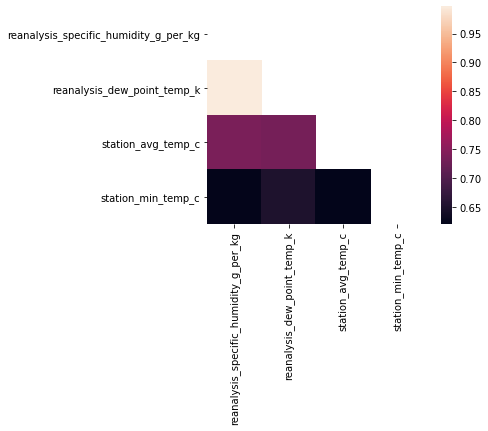

In [6]:
mask = np.zeros_like(df_features.corr())
mask[np.triu_indices_from(mask)] = True

#sns.set()
sns.heatmap(df_features.corr(),xticklabels=df_features.corr().columns,yticklabels=df_features.corr().columns, mask= mask,square=True, annot=False)

You have to select features, they can be all, but that is usually not a good idea, so here we will leave some selected.

In [ ]:
#scaler = StandardScaler()  #@param ["MinMaxScaler()", "StandardScaler()"] {type:"raw"}
#df_datanorm = scaler.fit_transform(df_features)

Now we are going to train the model with the training data

Min Value uniform : 24.10740469801817 (25)
Min Value distance : 24.128882042525298 (25)


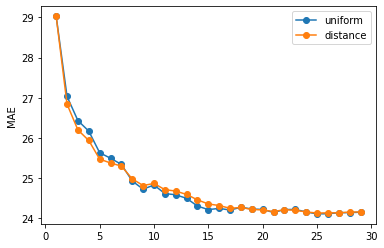

In [7]:
cv = KFold(n_splits = 5, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 

df_features['total_cases'] = df_labels['total_cases']


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(df_features):
          # División train test aleatoria
          f_train = df_features.loc[train_fold]
          f_test = df_features.loc[test_fold]

          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['total_cases'], axis=1), 
                               y = f_train['total_cases'])
          y_pred = knn.predict(X = f_test.drop(['total_cases'], axis = 1))

          # evaluación del modelo
          mae = mean_absolute_error(f_test['total_cases'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels['total_cases'], test_size=0.5, random_state=1)

# Submission result

We generate the output file according to the Submission format

Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.


In [9]:
# x axis for plotting

def KNN_Model(X_train, X_test):
    # constructor
    n_neighbors = 15 #@param {type:"slider", min:0, max:100, step:1}
    weights = 'uniform'
    knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
    # fit and predict

    knn.fit( X = X_train.drop(['total_cases'], axis=1), y = X_train['total_cases'])
    y_pred = knn.predict(X = X_test.drop(['total_cases'], axis = 1))
    mae = mean_absolute_error(X_test['total_cases'], y_pred)
    print('MAE', mae,'\n')
    xx = np.stack(i for i in range(X_test['total_cases'].shape[0]))
    plt.plot(xx, X_test['total_cases'], c='r', label='data')
    #plt.plot(xx, y, c='k', label='data')
    plt.plot(xx, y_pred, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                    weights))

    plt.show()
    return knn

MAE 22.165201465201466 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


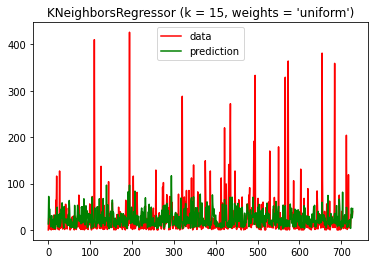

In [10]:
model = KNN_Model(X_train, X_test)

In [11]:
final_model_predictions = model.predict(df_test_final)

1. We carry out the prediction on the test.

Finally we try to visualize how our prediction has turned out with reality.

In [12]:
# round the result and cast to int
y = np.rint(final_model_predictions) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 17,  16,  22,  62,  16, 113,  32,  49,  42,  39,  31,  38,  32,
        50,  48,  34,  28,  46,  66,  52,  60,  17,   7,  70,  19,  30,
        62,  40,  27,  30,  22,  15,  20,  15,  20,  37,  17,  18,  23,
        32,  20,  19,  13,  16,  21,  14,  16,  13,  16,  18,  12,  11,
        16,  18,  19,  33,  40,  54,  66,  63,  77,  55,  34,  41,  26,
        30,  47,  38,  40,  39,  42,  28,  44,  41,  48,  39,  42,  26,
        47,  81,  19,  36,  31,  29,  27,  34,  16,  37,  31,  26,  28,
        38,  22,  17,  14,  18,  27,  15,  16,  20,  19,  10,  19,  49,
        40,  22,  27,  34,  53,  57,  58,  37,  31,  23,  55,  65,  42,
        15,  40,  59,  41,  66,  55,  65,  63,  36,  37,  41,  50,  38,
        81,  44,  35,  33,  20,  21,  22,  33,  18,  19,  24,  29,  23,
        21,  18,  16,  17,  19,  16,  18,  17,  14,  18,  16,  16,  16,
        13,  57,  17,   7,  12,  29,  18,  25,  19,  25,  55,  42,  20,
        50,  52,  21,  54,  66,  18,  38,  49,  16,  54,  51,  3

3. We build the output file


In [ ]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])


submission.total_cases = final_model_predictions.astype(np.int64)
submission.to_csv("result.csv")

Upload new submission
Woohoo! We processed your submission!
Your score for this submission is:

28.5385
Woo! I scored 28.5385 on 'DengAI: Predicting Disease Spread'!